Copyright (C) 2024 Konstantin Touev  
All Rights Reserved.

Portions of this file include code from https://github.com/langchain-ai/langchain, which is licensed under the MIT License.

In [7]:
from file_processing.llm_chat_support import get_llm, LLMTemp

if __name__ == "__main__":
    from dotenv import load_dotenv

    load_dotenv()

from langchain.chains.query_constructor.schema import AttributeInfo

from file_processing.query_processor.basic_rule_extractor import query_to_structured_filter

from matplotlib import pyplot as plt

When writing metadata filtering rules, we want them to be editable and understandable by the users.  
Therefore we compare how many operators are used my basic rules implementation and the standard Text-to-SQL implementation from Langchain.

In [54]:
from langchain_core.structured_query import Comparison, Operation
import pandas as pd
from langchain.chains.query_constructor.base import load_query_constructor_runnable

# Generally thank you https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/self_query
# Thank you https://github.com/langchain-ai/langchain/blob/master/cookbook/self_query_hotel_search.ipynb
# Thank you, ChatGPT for helping me come up with some of the example data.

# Hotel Search
doc_contents_hotel = "A detailed description of a hotel room, including information about the room type and room amenities."
metadata_field_info_hotel = [
    AttributeInfo(name="onsiterate", description="The rate of the room", type="float"),
    AttributeInfo(name="maxoccupancy", description="Maximum number of people that can occupy the room", type="integer"),
    AttributeInfo(name="city", description="City where the hotel is located", type="string"),
    AttributeInfo(name="country", description="Country where the hotel is located", type="string"),
    AttributeInfo(name="starrating", description="Star rating of the hotel", type="integer"),
    AttributeInfo(name="mealsincluded", description="Whether meals are included", type="boolean")
]

# Music Search
doc_contents_music = "Lyrics of a song"
metadata_field_info_music = [
    AttributeInfo(name="artist", description="Name of the song artist", type="string"),
    AttributeInfo(name="length", description="Length of the song in seconds", type="integer"),
    AttributeInfo(name="genre", description="The song genre, e.g., 'pop', 'rock', 'rap'", type="string")
]

# Document Search
doc_contents_docs = "The full text of the document"
metadata_field_info_docs = [
    AttributeInfo(name="title", description="Title of the document", type="string"),
    AttributeInfo(name="author", description="Author of the document", type="string"),
    AttributeInfo(name="publication_date", description="Date when the document was published", type="date")
]

examples = [
    {
        "example_number": "Hotel Example",
        "unstructured_query": "I want a hotel in either Berlin or Munich with free Wi-Fi or free breakfast, under $150 per night",
        "doc_contents": doc_contents_hotel,
        "metadata_field_info": metadata_field_info_hotel,
    },
    {
        "example_number": "Music Example",
        "unstructured_query": "Find songs by artists other than Ed Sheeran or Taylor Swift, longer than 4 minutes, in the genre pop or rock",
        "doc_contents": doc_contents_music,
        "metadata_field_info": metadata_field_info_music,
    },
    {
        "example_number": "Documents Example",
        "unstructured_query": "Find documents mentioning 'climate change' or 'global warming' published after 2022",
        "doc_contents": doc_contents_docs,
        "metadata_field_info": metadata_field_info_docs,
    },
]

data = {
    'example': [],
    'version': [],
    'comparators': [],
    'operators': [],
    'comparators_used': [],
    'operators_used': []
}

def parse_langchain_implementation(output):
    comparators = []
    operators = []

    def go_into(node):
        if isinstance(node, Comparison):
            comparators.append(node.comparator.value)
        elif isinstance(node, Operation):
            operators.append(node.operator.value)
            for arg in node.arguments:
                go_into(arg)

    if hasattr(output, 'filter') and output.filter is not None:
        go_into(output.filter)
        
    return comparators, operators


def parse_own_implementation(output):
    comparisons = [comp['comparator'] for comp in output.get('filter', [])]
    # All is in an AND statement, but we don't mention it everytime
    logical_operators = []
    return comparisons, logical_operators

for example in examples:
    example_name = example['example_number']
    unstructured_query = example['unstructured_query']
    doc_contents = example['doc_contents']
    metadata_field_info = example['metadata_field_info']
    
    display(example_name)
    display(unstructured_query)

    chain = load_query_constructor_runnable(
        get_llm(LLMTemp.NO_IMAGINATION),
        doc_contents,
        metadata_field_info,
        fix_invalid=True
    )
    res_standard = chain.invoke({"query": unstructured_query})
    local_comparators, local_operators = parse_langchain_implementation(res_standard)

    display(res_standard)

    data['example'].append(example_name)
    data['version'].append('Langchain')
    data['comparators'].append(len(local_comparators))
    data['operators'].append(len(local_operators))
    data['comparators_used'].append(local_comparators)
    data['operators_used'].append(local_operators)

    basic_rules = query_to_structured_filter(
        unstructured_query,
        doc_contents,
        metadata_field_info
    )
    
    display(basic_rules)

    local_comparators, local_operators = parse_own_implementation(basic_rules)

    data['example'].append(example_name)
    data['version'].append('Basic Rules (mine)')
    data['comparators'].append(len(local_comparators))
    data['operators'].append(len(local_operators))
    data['comparators_used'].append(local_comparators)
    data['operators_used'].append(local_operators)
    
    display("*"*100)

df_operators = pd.DataFrame(data)
display(df_operators)


'Hotel Example'

'I want a hotel in either Berlin or Munich with free Wi-Fi or free breakfast, under $150 per night'

StructuredQuery(query='free Wi-Fi or free breakfast', filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='city', value='Berlin'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='city', value='Munich')]), Comparison(comparator=<Comparator.LT: 'lt'>, attribute='onsiterate', value=150)]), limit=None)

{'filter': [{'value': '(Berlin|Munich)',
   'attribute': 'city',
   'comparator': 'regex_match'},
  {'value': 150.0, 'attribute': 'onsiterate', 'comparator': 'lt'}],
 'reason_for_no_filter': "Query includes unsupported 'or' conditions for amenities like free Wi-Fi or free breakfast"}

'****************************************************************************************************'

'Music Example'

'Find songs by artists other than Ed Sheeran or Taylor Swift, longer than 4 minutes, in the genre pop or rock'

StructuredQuery(query=' ', filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='genre', value='pop'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='genre', value='rock')]), Comparison(comparator=<Comparator.GT: 'gt'>, attribute='length', value=240), Operation(operator=<Operator.NOT: 'not'>, arguments=[Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='artist', value='Ed Sheeran'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='artist', value='Taylor Swift')])])]), limit=None)

{'filter': [{'value': '(?i)^(?!.*(Ed Sheeran|Taylor Swift)).*$',
   'attribute': 'artist',
   'comparator': 'regex_match'},
  {'value': 240, 'attribute': 'length', 'comparator': 'gt'},
  {'value': '(?i)^(pop|rock)$',
   'attribute': 'genre',
   'comparator': 'regex_match'}],
 'reason_for_no_filter': ''}

'****************************************************************************************************'

'Documents Example'

"Find documents mentioning 'climate change' or 'global warming' published after 2022"

StructuredQuery(query='climate change global warming', filter=Comparison(comparator=<Comparator.GT: 'gt'>, attribute='publication_date', value={'date': '2022-01-01', 'type': 'date'}), limit=None)

{'filter': [{'value': '(climate change|global warming)',
   'attribute': 'content',
   'comparator': 'regex_match'},
  {'value': '2022-01-01',
   'attribute': 'publication_date',
   'comparator': 'gt'}],
 'reason_for_no_filter': ''}

'****************************************************************************************************'

,example,version,comparators,operators,comparators_used,operators_used
0,Hotel Example,Langchain,3,2,"[eq, eq, lt]","[and, or]"
1,Hotel Example,Basic Rules (mine),2,0,"[regex_match, lt]",[]
2,Music Example,Langchain,5,4,"[eq, eq, gt, eq, eq]","[and, or, not, or]"
3,Music Example,Basic Rules (mine),3,0,"[regex_match, gt, regex_match]",[]
4,Documents Example,Langchain,1,0,[gt],[]
5,Documents Example,Basic Rules (mine),2,0,"[regex_match, gt]",[]


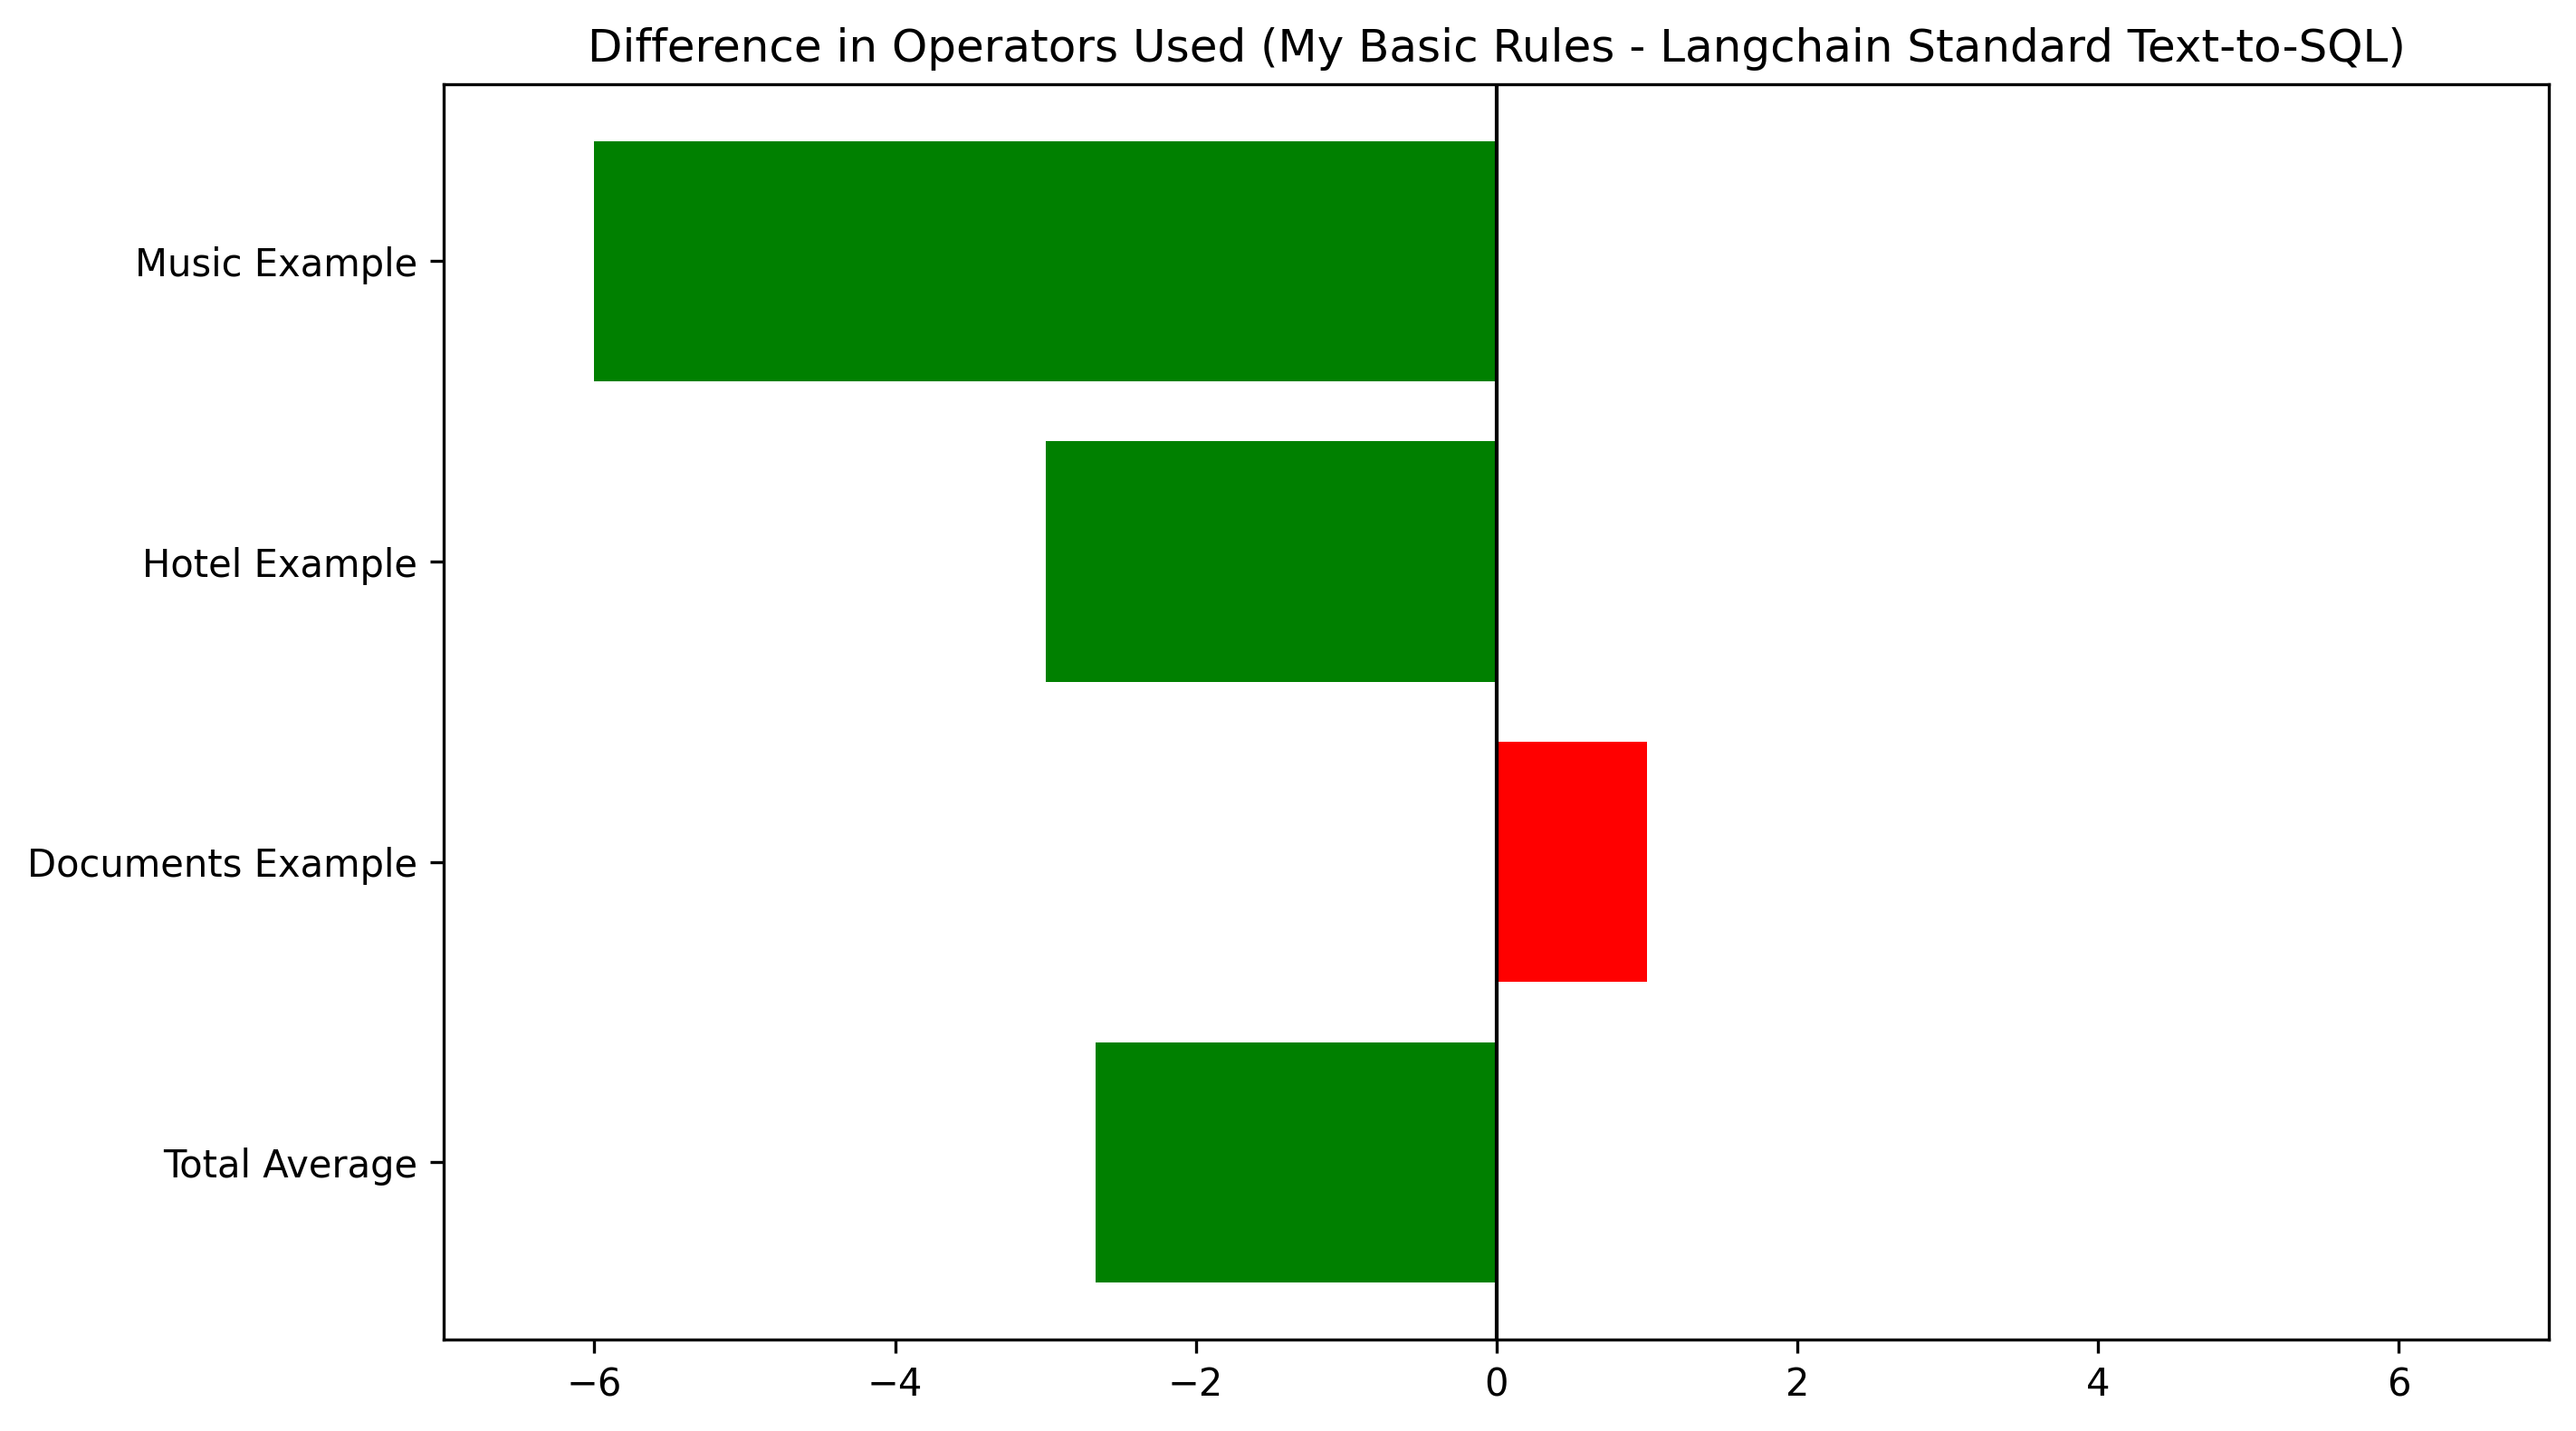

In [55]:
df_operators['any_operation'] = df_operators['comparators'] + df_operators[
    'operators']

df_pivot = df_operators.pivot(index='example', columns='version',
                              values='any_operation').reset_index()
df_pivot['difference'] = df_pivot['Basic Rules (mine)'] - df_pivot['Langchain']

total_average = df_pivot['difference'].mean()

df_pivot_with_avg = pd.concat([
    pd.DataFrame(
        {'example': 'Total Average', 'Basic Rules (mine)': total_average, 'Langchain': total_average, 'difference': total_average},
        index=[0]),
    df_pivot
]).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

colors = ['red' if diff > 0 else 'green' for diff in df_pivot_with_avg['difference']]
bars = ax.barh(df_pivot_with_avg['example'],
               df_pivot_with_avg['difference'],
               color=colors)

ax.axvline(0, color='black', linewidth=1)

ax.set_title('Difference in Operators Used (My Basic Rules - Langchain Standard Text-to-SQL)')
ax.set_xlabel('')

# Show the scale
max_diff = df_pivot_with_avg['difference'].abs().max() + 1
ax.set_xlim(-max_diff, max_diff)

plt.show()

We see that my implementation for basic rules is just as powerful by making use of regex.  
The only 'loss' for basic rules is when the langchain implementation failed to correctly utilise the title attribute for the documents example and had one less constraint.